# Studying Validation Loss of Test Set With and Without Dropout
In this section we see how our model generalizes to never before seen data. What we will discover is that after a certain number of epochs, our model will begin to perform worse on data it hasn't seen before. This is a sign of over-fitting, and is combated through dropout. 

In [1]:
import torch
import torch.nn.functional as F
from torch import nn, optim
from torchvision import datasets, transforms
import numpy as np

from collections import OrderedDict

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_palette(sns.color_palette("bright", n_colors=10,))

In [2]:
transform = transforms.Compose([transforms.ToTensor(),
                               transforms.Normalize((0.5,), (0.5,))])

trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

## Without Dropout: 
Let's write a simple network without dropout, train and track its losses.

In [3]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)
    
    def forward(self, x):
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return F.log_softmax(self.fc4(x), dim=1)

In [4]:
model = Classifier()
criterion = nn.NLLLoss()
opt = optim.Adam(model.parameters(), lr = 0.003)
epochs = 20

train_losses = []
test_losses = []
accuracy = []

for e in range(epochs):
    test_loss = 0
    train_loss = 0
    acc = 0
    for images, labels in trainloader:
        opt.zero_grad()
        loss = criterion(model(images), labels)
        loss.backward()
        opt.step()
        train_loss += loss.item()
    train_losses.append(train_loss/len(trainloader))
    
    with torch.no_grad():
        model.eval()
        for images, labels in testloader:
            logps = model(images)
            loss = criterion(logps, labels)
            test_loss += loss.item()
            
            ps = torch.exp(logps)
            _, top_class = ps.topk(1, dim = 1)
            equals = (top_class == labels.view(*top_class.shape)).numpy()
            acc += equals.mean()
            
        accuracy.append(acc/len(testloader))
        test_losses.append(test_loss/len(testloader))

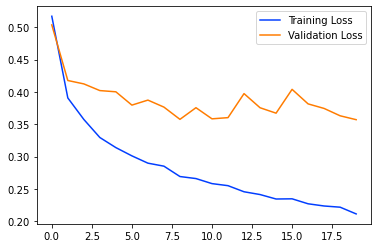

In [5]:
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Validation Loss')
plt.legend()

## With Dropout
Next, let's write another model but this time with dropout included. We'll include a reusable training method in this class. No point in writing the same code over and over again. 

In [6]:
class DOClassifier(nn.Sequential):
    def __init__(self, layers):
        self.layers = layers
        super().__init__(self.init_modules(layers))
    
    def init_modules(self, layers):
        n_layers = len(layers)
        modules = OrderedDict()
        
        for i in range(n_layers - 2):
            modules[f'fc{i}']   = nn.Linear(layers[i], layers[i+1])
            modules[f'ReLu{i}'] = nn.ReLU()  
            modules[f'drop{i}'] = nn.Dropout(p=0.2)
        modules['fc_out'] = nn.Linear(layers[-2], layers[-1])
        modules['smax_out'] = nn.LogSoftmax(dim=1)   
        
        return modules
    
    def train_model(self, trainload, epochs, criterion=nn.NLLLoss(), optimizer=optim.Adam, lr=0.003, testload=None):
        """
        Train network parameters for given number of epochs.


        :param trainloader: a DataLoader object containing training variables and targets.
        :param epochs: Number of times the network will view the entire dataset
        :param optimizer: Learning method. Default optim.Adam
        :param lr: Learning Rate. Default 0.01
        :param criterion: Loss function. defualt nn.NLLLoss,
        :param plot_loss: Set to True for a plot of training loss vs epochs.
        :return:
        """
        opt = optimizer(self.parameters(), lr)
        
        self.testload = testload
        self.train_loss = []
        self.valid_loss = []
        self.accuracy   = []

        for e in range(epochs):
            running_tl = 0
            running_vl = 0
            running_ac = 0
            for x, y in trainload:
                x = x.view(x.shape[0], -1)
                opt.zero_grad()
                loss = criterion(self(x), y)
                loss.backward()
                opt.step()
                running_tl += loss.item()

            if testload != None:
                self.eval()
                with torch.no_grad():
                    for x, y in testload:
                        x = x.view(x.shape[0], -1)
                        lps = self(x)
                        ps = torch.exp(lps)
                        loss = criterion(lps, y)
                        _, topclass = ps.topk(1, dim=1)
                        acc = (topclass == y.view(*topclass.shape)).numpy()
                        running_ac += acc.mean()
                        running_vl += loss.item()
                    self.accuracy.append(running_ac/len(testload))
                    self.valid_loss.append(running_vl/len(testload))
                
            self.train()
            self.train_loss.append(running_tl/len(trainload))
    
    def plot_loss(self):
        if self.valid_loss:
            plt.plot(self.valid_loss, label='Validation Loss')
        plt.plot(self.train_loss, label='Training Loss')
        plt.legend()

In [7]:
model2 = DOClassifier((784,256,128,64,10))

In [8]:
model2.train_model(trainloader, 20, testload=testloader)

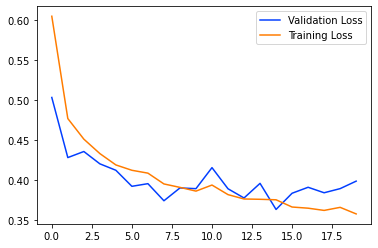

In [9]:
model2.plot_loss()

## Save Model Architecture and Trained Weights
We'll define a small function that saves our model's layer architecture and trained weights. Note that this function is specific to the the class we wrote above called `DOClassifier`. If you define your network class differently, you may need to save your checkpoints in a different way.

In [10]:
def save_checkpoint(model): 
    checkpoint = {
        'layers': model.layers,
        'state_dict': model.state_dict()
    }
    torch.save(checkpoint, 'chckpoint.pth')

def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    model = DOClassifier(checkpoint['layers'])
    model.load_state_dict(checkpoint['state_dict'])
    return model

save_checkpoint(model2)

## Check to see if our model properly saved and loaded:
We'll compare `model2` with `model3`, where `model3` was created by loading our checkpoint from file.

In [11]:
model2.layers

(784, 256, 128, 64, 10)

In [12]:
model2.state_dict()['fc0.weight']

tensor([[ 0.1895,  0.1610,  0.1723,  ...,  0.1874,  0.2213,  0.2024],
        [ 0.1956,  0.2496,  0.2213,  ...,  0.2568,  0.2186,  0.2090],
        [-0.2020, -0.1504, -0.2025,  ..., -0.2292, -0.1865, -0.1821],
        ...,
        [ 0.3308,  0.3273,  0.3853,  ...,  0.3952,  0.3763,  0.3959],
        [ 0.1360,  0.1809,  0.1597,  ...,  0.0811,  0.1266,  0.1550],
        [ 0.2551,  0.2899,  0.2208,  ...,  0.2371,  0.2434,  0.2662]])

In [13]:
model3 = load_checkpoint('chckpoint.pth')

In [14]:
model3.state_dict()['fc0.weight']

tensor([[ 0.1895,  0.1610,  0.1723,  ...,  0.1874,  0.2213,  0.2024],
        [ 0.1956,  0.2496,  0.2213,  ...,  0.2568,  0.2186,  0.2090],
        [-0.2020, -0.1504, -0.2025,  ..., -0.2292, -0.1865, -0.1821],
        ...,
        [ 0.3308,  0.3273,  0.3853,  ...,  0.3952,  0.3763,  0.3959],
        [ 0.1360,  0.1809,  0.1597,  ...,  0.0811,  0.1266,  0.1550],
        [ 0.2551,  0.2899,  0.2208,  ...,  0.2371,  0.2434,  0.2662]])

## All done.
Looks like the first layer's weights are identical.